In [1]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
import os

In [2]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, reduce, repeat
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
import torch.nn.functional as F
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.ops.misc import FrozenBatchNorm2d
import torch.nn as nn
from torch import einsum
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")


CUDA is available. Using GPU.


## Exploratory Data Analysis (EDA)

In [5]:
# Load the annotations into a DataFrame
annotations_df = pd.read_csv("D:\\SwinV2_VinDrCXRDataSet\\train.csv\\train.csv")

In [6]:
annotations_df

image_id          class_name  class_id rad_id  \
0      50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1      21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2      9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3      051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4      063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
...                                 ...                 ...       ...    ...   
67909  936fd5cff1c058d39817a08f58b72cae          No finding        14     R1   
67910  ca7e72954550eeb610fe22bf0244b7fa          No finding        14     R1   
67911  aa17d5312a0fb4a2939436abca7f9579          No finding        14     R8   
67912  4b56bc6d22b192f075f13231419dfcc8        Cardiomegaly         3     R8   
67913  5e272e3adbdaafb07a7e84a9e62b1a4c          No finding        14    R16   

        x_min   y_min   x_max   y_max  
0         NaN     NaN     NaN     NaN  
1         NaN     NaN     NaN     NaN  
2       691.0  1375.0  1653.0  1831.0  
3      1264.0   743.0  1611.0  1019.0  
4         NaN     NaN     NaN     NaN  
...       ...     ...     ...     ...  
67909     NaN     NaN     NaN     NaN  
67910     NaN     NaN     NaN     NaN  
67911     NaN     NaN     NaN     NaN  
67912   771.0   979.0  1680.0  1311.0  
67913     NaN     NaN     NaN     NaN  

[67914 rows x 8 columns]

In [7]:
# Basic statistics
print(annotations_df.head())

                           image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN  


In [8]:
# Distribution of classes
print(annotations_df['class_name'].value_counts())

# Number of findings per image
findings_per_image = annotations_df.groupby('image_id').size()
print(findings_per_image.describe())

# Explore annotations by radiologist
annotations_per_radiologist = annotations_df.groupby('rad_id').size()
print(annotations_per_radiologist.describe())

class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64
count    15000.000000
mean         4.527600
std          3.582638
min          3.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         57.000000
dtype: float64
count       17.000000
mean      3994.941176
std       4716.168671
min        812.000000
25%       1729.000000
50%       1824.000000
75%       2783.000000
max      15708.000000
dtype: float64


## Managing No Finding Class 

For each test image, you will be predicting a bounding box and class for all findings. If you predict that there are no findings, you should create a prediction of "14 1 0 0 1 1" (14 is the class ID for no finding, and this provides a one-pixel bounding box with a confidence of 1.0).

In [9]:
preprocess_df = annotations_df[["image_id", "class_id", "x_min", "y_min", "x_max", "y_max"]]
preprocess_df.x_min = preprocess_df.x_min.fillna(0)
preprocess_df.y_min = preprocess_df.y_min.fillna(0)
preprocess_df.x_max = preprocess_df.x_max.fillna(1)
preprocess_df.y_max = preprocess_df.y_max.fillna(1)
preprocess_df.head()

C:\Users\karti\AppData\Local\Temp\ipykernel_4512\2056373877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_df.x_min = preprocess_df.x_min.fillna(0)
C:\Users\karti\AppData\Local\Temp\ipykernel_4512\2056373877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_df.y_min = preprocess_df.y_min.fillna(0)
C:\Users\karti\AppData\Local\Temp\ipykernel_4512\2056373877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

image_id  class_id   x_min   y_min   x_max   y_max
0  50a418190bc3fb1ef1633bf9678929b3        14     0.0     0.0     1.0     1.0
1  21a10246a5ec7af151081d0cd6d65dc9        14     0.0     0.0     1.0     1.0
2  9a5094b2563a1ef3ff50dc5c7ff71345         3   691.0  1375.0  1653.0  1831.0
3  051132a778e61a86eb147c7c6f564dfe         0  1264.0   743.0  1611.0  1019.0
4  063319de25ce7edb9b1c6b8881290140        14     0.0     0.0     1.0     1.0

In [10]:
preprocess_df.shape

(67914, 6)

In [11]:
preprocess_df.image_id.unique().shape

(15000,)

In [12]:
valid_bboxes =  preprocess_df.apply(lambda row: row['x_min'] < row['x_max'] and row['y_min'] < row['y_max'], axis=1)
preprocess_df =  preprocess_df[valid_bboxes]
preprocess_df

image_id  class_id   x_min   y_min   x_max  \
0      50a418190bc3fb1ef1633bf9678929b3        14     0.0     0.0     1.0   
1      21a10246a5ec7af151081d0cd6d65dc9        14     0.0     0.0     1.0   
2      9a5094b2563a1ef3ff50dc5c7ff71345         3   691.0  1375.0  1653.0   
3      051132a778e61a86eb147c7c6f564dfe         0  1264.0   743.0  1611.0   
4      063319de25ce7edb9b1c6b8881290140        14     0.0     0.0     1.0   
...                                 ...       ...     ...     ...     ...   
67909  936fd5cff1c058d39817a08f58b72cae        14     0.0     0.0     1.0   
67910  ca7e72954550eeb610fe22bf0244b7fa        14     0.0     0.0     1.0   
67911  aa17d5312a0fb4a2939436abca7f9579        14     0.0     0.0     1.0   
67912  4b56bc6d22b192f075f13231419dfcc8         3   771.0   979.0  1680.0   
67913  5e272e3adbdaafb07a7e84a9e62b1a4c        14     0.0     0.0     1.0   

        y_max  
0         1.0  
1         1.0  
2      1831.0  
3      1019.0  
4         1.0  
...       ...  
67909     1.0  
67910     1.0  
67911     1.0  
67912  1311.0  
67913     1.0  

[67914 rows x 6 columns]

## Visualization of Images and Annotations

In [13]:
# def load_dicom_image(path):
#     dicom = pydicom.dcmread(path)
#     data = apply_voi_lut(dicom.pixel_array, dicom)  # VOI LUT is applied to get the correct values
    
#     # Convert to PIL Image for compatibility with torchvision transforms
#     if dicom.PhotometricInterpretation == "MONOCHROME1":
#         data = np.max(data) - data  # Inverting the image if needed
#     data = data - np.min(data)
#     data = data / np.max(data)
#     data = (data * 255).astype(np.uint8)
#     image = Image.fromarray(data)
#     return image
    

In [14]:
# def plot_image_with_annotations(image_id, preprocess_df):
#     # Adjust the base path according to your dataset location
#     base_path = "D:/SwinV2_VinDrCXRDataSet/train/"
    
#     image_path = f"{base_path}{image_id}.dicom"  # Adjusted for .dicom extension
#     image = load_dicom_image(image_path)
#     plt.imshow(image, cmap='gray')
    
#     annotations = preprocess_df[preprocess_df['image_id'] == image_id]
#     print(annotations)
#     for index, row in annotations.iterrows():
#         plt.gca().add_patch(plt.Rectangle((row['x_min'], row['y_min']),
#                                           row['x_max'] - row['x_min'],
#                                           row['y_max'] - row['y_min'],
#                                           linewidth=1, edgecolor='r', facecolor='none'))
#     plt.show()
    
# # Example usage with a specific image ID
# unique_image_ids = preprocess_df['image_id']

# for image_id in unique_image_ids[:5]:
#     plot_image_with_annotations(image_id, preprocess_df)


## Splitting Dataset into train and Validation Sets

In [15]:
from sklearn.model_selection import train_test_split

# Assuming 'annotations_df' is your DataFrame loaded from the CSV file
train_df, val_df = train_test_split(
    preprocess_df,
    test_size=0.2,   # 20% validation set
    stratify=preprocess_df['class_id'], # stratify by 'class_id' to maintian distribution
    random_state=42 # for reproducibility
)

#save these to csv files
#train_df.to_csv('train_annotations.csv', index=False)
#val_df.to_csv('val_annotations.csv', index=False)
    

In [16]:
train_df

image_id  class_id   x_min   y_min   x_max  \
33802  8fc79a203e64c849cd6b176be004534d        14     0.0     0.0     1.0   
52370  6a69a393d7beccc1043d5ee8cf0517d4        10   188.0  1759.0   305.0   
43527  ac3e0af6a22d73ed96f05d43037a1e7a         8  1841.0  1750.0  2120.0   
17892  c2c3e9e459681d13dc94b916a3689de4        14     0.0     0.0     1.0   
58442  fa7b469e21cf7a4e7afe9f17cf721259         6  2099.0   899.0  2581.0   
...                                 ...       ...     ...     ...     ...   
44008  f52c1bf308db55a73521eb1a048b1c92         8   650.0  1729.0   900.0   
18621  377b56ae5dc0492da6c9c79018928041        14     0.0     0.0     1.0   
46302  414ae85a6ec97db19ed913bde0062b11        10  2180.0  2482.0  2253.0   
2608   4b001bab36d94f73c1ead3ab74690dbc         8  1557.0  1014.0  1578.0   
55342  3479c81736f275a848b74d952ebfab29         9  1185.0   767.0  1380.0   

        y_max  
33802     1.0  
52370  1865.0  
43527  2003.0  
17892     1.0  
58442  1612.0  
...       ...  
44008  2083.0  
18621     1.0  
46302  2677.0  
2608   1041.0  
55342  1076.0  

[54331 rows x 6 columns]

In [17]:
val_df

image_id  class_id   x_min   y_min   x_max  \
66612  ff60d1425ffd67d12aa61e3eb3b45040        10  1784.0  1977.0  1883.0   
9117   02acf0e7d0932f9c6a06fd4bbe1f5d90         0  1619.0   629.0  1894.0   
57429  22b7917fc08a3eb226411d76e820ce05        14     0.0     0.0     1.0   
15347  573a4270587b6c660f567c741d4fb32f        14     0.0     0.0     1.0   
43751  7d084c9a42f2afea0089aa08932a6516        13   842.0   838.0   880.0   
...                                 ...       ...     ...     ...     ...   
27780  8bbf80bd095c75b2207ef57a277a661d        10  1687.0  2216.0  1832.0   
28361  2f4bc0f22545fa58a89bfa13cc083191        11  1745.0   577.0  2023.0   
57146  fc979a294242406c565414d75dd68f9f         0  1453.0   756.0  1864.0   
869    685037ea9d22358b9c189334a75e00e1        14     0.0     0.0     1.0   
60415  f769eea17a2e7678f481f386c3c6261c        13  1657.0  1338.0  1946.0   

        y_max  
66612  2120.0  
9117    949.0  
57429     1.0  
15347     1.0  
43751   901.0  
...       ...  
27780  2374.0  
28361   701.0  
57146  1291.0  
869       1.0  
60415  1473.0  

[13583 rows x 6 columns]

## Set Up Dynamic Data Augmentation and Preprocessing

In [18]:
class VinDrCXRDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        """
        Initialize the dataset.
        Args:
            annotations (pd.DataFrame): Dataframe with annotations.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = annotations #[annotations['class_id'] != 14]  # Exclude non-findings
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations['image_id'].unique())

    def __getitem__(self, idx):
        img_id = self.annotations['image_id'].unique()[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.dicom")
        dicom_file = pydicom.dcmread(img_path)
        image = apply_voi_lut(dicom_file.pixel_array, dicom_file)
        if dicom_file.PhotometricInterpretation == "MONOCHROME1":
            image = np.max(image) - image
        
        image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255.0  # Normalize
        image = image.astype(np.uint8)  # Convert to uint8
        
        
        image = np.expand_dims(image, axis=-1)  # Expand dims to [H, W, C]
        
        records = self.annotations[self.annotations['image_id'] == img_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = records['class_id'].values
        
        if self.transform:
            # Ensure transform supports receiving a single channel image and modifies boxes and labels accordingly.
            transformed = self.transform(image=image, bboxes=boxes, class_labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['class_labels']
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.long)

        target = {"boxes": boxes, "labels": labels}
        
        # Print the image shape after transformations
        print(f"Transformed image shape: {image.shape}")
        # If your transform already handles the conversion to tensor and dimension rearrangement, you can skip these.
        # if not isinstance(image, torch.Tensor):
        #     image = np.transpose(image, (2, 0, 1))  # Convert to [C, H, W]
        #     image = torch.tensor(image, dtype=torch.float)  # Ensure tensor type

        return image, target

Define Transformations

In [19]:
# Define your transformations
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485], std=[0.229], max_pixel_value=255.0),  # Adjusted for single-channel
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485], std=[0.229], max_pixel_value=255.0),  # Adjusted for single-channel
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


Loading

In [20]:
# Adjust the paths accordingly
#csv_file = "D:\\SwinV2_VinDrCXRDataSet\\train.csv\\train.csv"
img_dir = "D:\\SwinV2_VinDrCXRDataSet\\train"
print(train_df[:10])
train_dataset = VinDrCXRDataset(train_df[:10], img_dir, transform=train_transforms)
val_dataset = VinDrCXRDataset(val_df[:10], img_dir, transform=val_transforms)

                               image_id  class_id   x_min   y_min   x_max  \
33802  8fc79a203e64c849cd6b176be004534d        14     0.0     0.0     1.0   
52370  6a69a393d7beccc1043d5ee8cf0517d4        10   188.0  1759.0   305.0   
43527  ac3e0af6a22d73ed96f05d43037a1e7a         8  1841.0  1750.0  2120.0   
17892  c2c3e9e459681d13dc94b916a3689de4        14     0.0     0.0     1.0   
58442  fa7b469e21cf7a4e7afe9f17cf721259         6  2099.0   899.0  2581.0   
66457  aabc4acd6a8f6c27828a11701675a6e7         9   784.0    76.0  1153.0   
41133  ca96c5f3611278776d1f6027bbd41005         3   888.0  1410.0  1938.0   
54825  18b362567e282e3ada32ee486ea6bad1         2  1911.0   739.0  2000.0   
24017  1b2a7adb5705d9e3f5b63939046d93c7         5   379.0   885.0  1089.0   
3501   765760a9e2d3b82da72ca1ab86229b79        13   341.0   708.0   908.0   

        y_max  
33802     1.0  
52370  1865.0  
43527  2003.0  
17892     1.0  
58442  1612.0  
66457  1902.0  
41133  1812.0  
54825   820.0  
24017  2

In [21]:
# Assuming you're using your train_dataset
image, target = train_dataset[0]  # Get the first sample

print(f"Shape of the processed image: {image.shape}")
# This should output: Shape of the processed image: torch.Size([1, 224, 224])


Transformed image shape: torch.Size([1, 224, 224])
Shape of the processed image: torch.Size([1, 224, 224])


Plotting Images 

Transformed image shape: torch.Size([1, 224, 224])


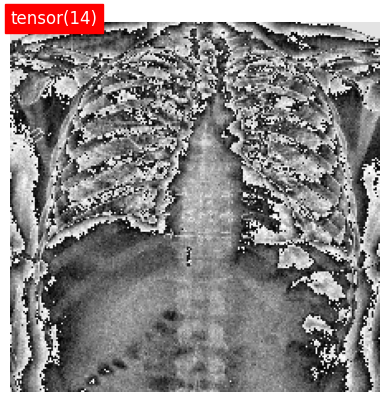

Transformed image shape: torch.Size([1, 224, 224])


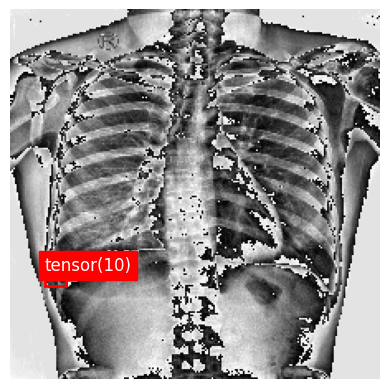

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


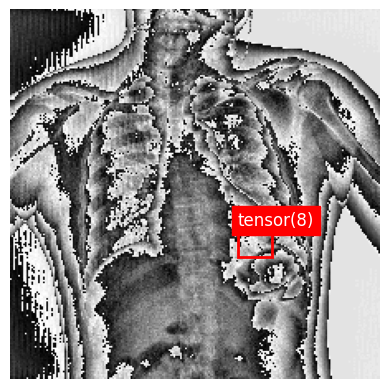

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


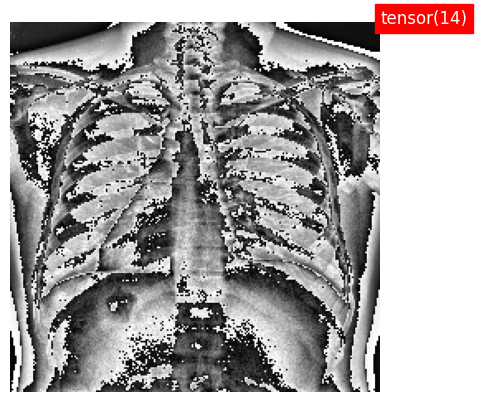

Transformed image shape: torch.Size([1, 224, 224])


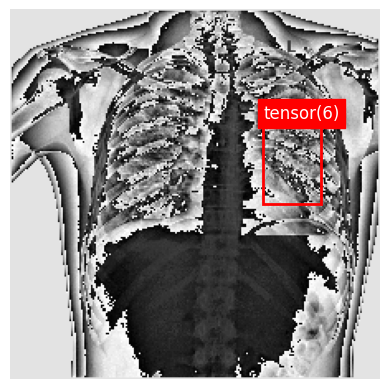

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


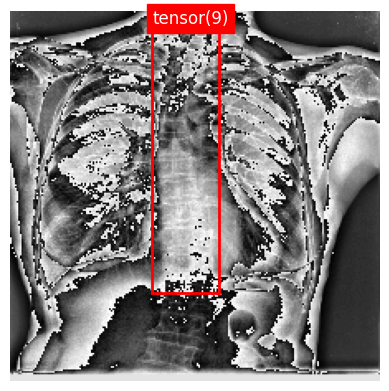

Transformed image shape: torch.Size([1, 224, 224])


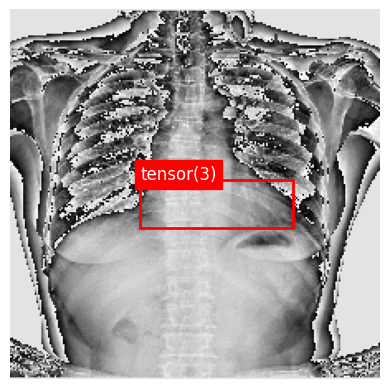

Transformed image shape: torch.Size([1, 224, 224])


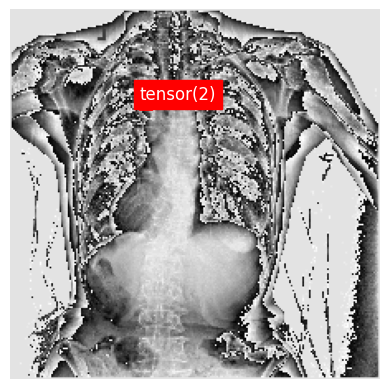

Transformed image shape: torch.Size([1, 224, 224])


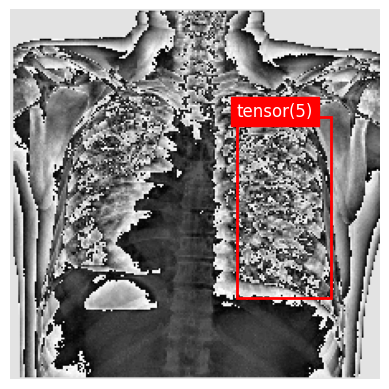

Transformed image shape: torch.Size([1, 224, 224])


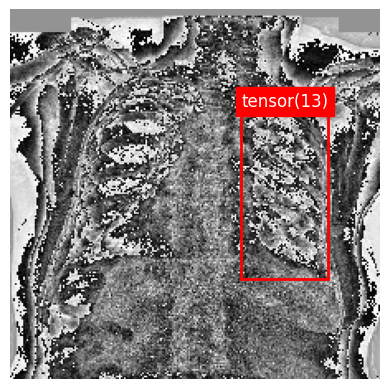

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


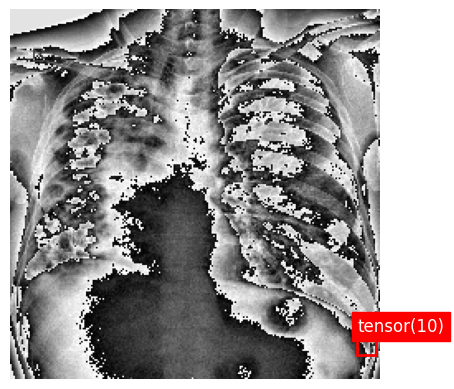

Transformed image shape: torch.Size([1, 224, 224])


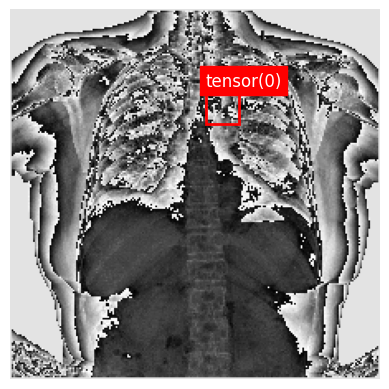

Transformed image shape: torch.Size([1, 224, 224])


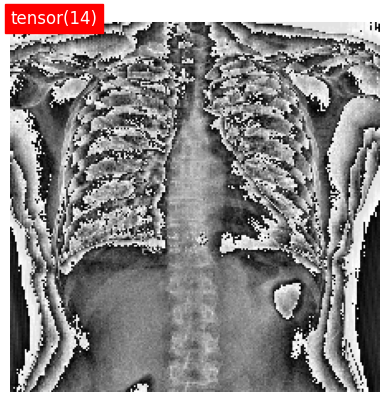

Transformed image shape: torch.Size([1, 224, 224])


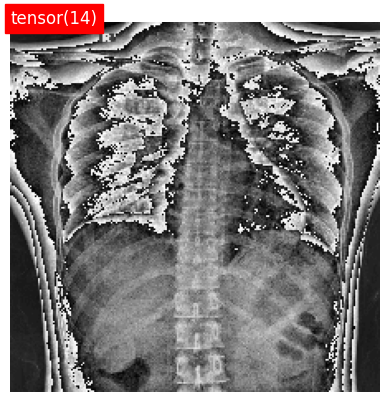

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


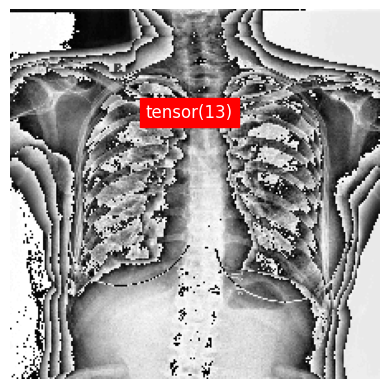

Transformed image shape: torch.Size([1, 224, 224])


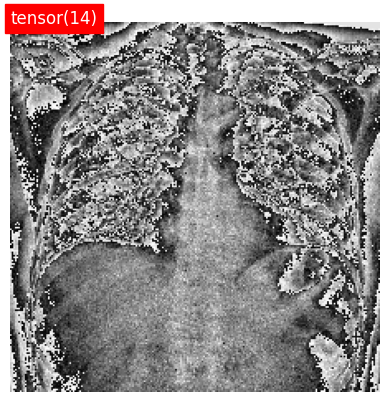

Transformed image shape: torch.Size([1, 224, 224])


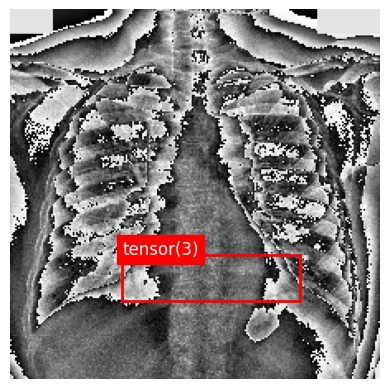

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


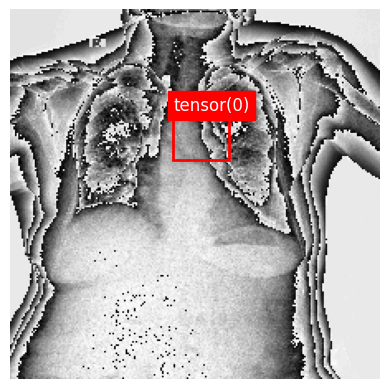

Transformed image shape: torch.Size([1, 224, 224])


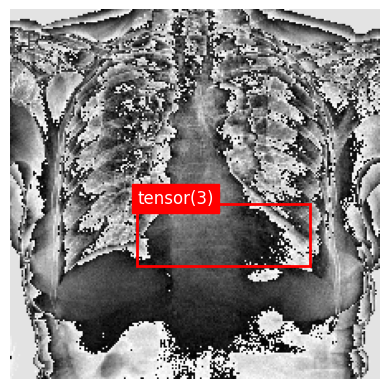

Transformed image shape: torch.Size([1, 224, 224])


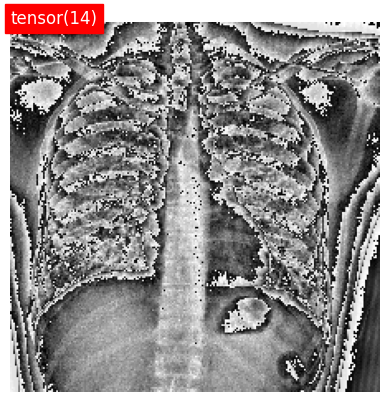

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

def show_image_with_boxes(image, boxes, labels):
    """
    Show an image with bounding boxes. Expects images in PyTorch tensor format.
    Args:
        image: A tensor of shape [C, H, W].
        boxes: A list of bounding boxes, each box being [x_min, y_min, x_max, y_max].
        labels: A list of labels for each bounding box.
    """
    # Convert the tensor image to PIL for easy display
    image = to_pil_image(image)

    # Create a new matplotlib figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')  # Display in grayscale
    #plt.title(f"Image ID: {img_id}")  # Display the image ID as the title

    # Add bounding boxes and labels to the image
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, str(label), color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')  # Hide axis
    plt.show()

# Visualize a few examples from the training set
for i in range(10):
    image, target = train_dataset[i]
    show_image_with_boxes(image, target["boxes"], target["labels"])

# Visualize a few examples from the validation set
for i in range(10):
    image, target = val_dataset[i]
    show_image_with_boxes(image, target["boxes"], target["labels"])


In [23]:
type(train_dataset)

__main__.VinDrCXRDataset

In [24]:
from torch.utils.data import DataLoader


def collate_fn(x):
    return tuple(zip(*x))
#from torchvision.transforms.functional import to_tensor, to_pil_image

# def collate_fn(batch):
#     images = []
#     targets = []
#     for img, target in batch:
#         # Ensure each image is a tensor of shape [C, H, W]
#         if not isinstance(img, torch.Tensor):
#             img = to_pil_image(img)  # Convert to PIL image first if not already
#             img = to_tensor(img)     # Then convert to tensor
#         images.append(img)
        
#         # Ensure targets are in a dictionary format expected by the model
#         targets.append(target)
    
#     return images, targets

In [25]:
train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True, pin_memory=True)

In [26]:
for images, targets in train_loader:
    print(f"Batch image shape: {images[0].shape}")  # Print shape of the first image in the batch
    break  # Only check the first batch to keep the output manageable


Transformed image shape: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Batch image shape: torch.Size([1, 224, 224])


In [27]:
for data in train_loader:
    images, targets, *other_info = data
    print(images, targets) # Handle or use the other_info as needed

Transformed image shape: torch.Size([1, 224, 224])


c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])
[tensor([[[-2.1008, -2.0665, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0494, -2.0323, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0665, -1.9980, -1.9638,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-1.2617, -0.6281, -0.3712,  ..., -0.4397, -0.5596, -0.5767],
         [-2.1008, -0.9705, -0.4739,  ..., -0.3027, -0.4739, -0.4911],
         [-2.1179, -1.7583, -0.7137,  ..., -0.4568, -0.4568, -0.6109]]]), tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.0323],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.0323, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.0323, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]])] [{'boxes': tensor([[0.0000, 0.0000, 0.0848, 0.0707]]), 'labels

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
[tensor([[[-0.8678, -0.8507, -0.8849,  ..., -1.0562, -1.0562, -1.0562],
         [-0.9363, -0.8164, -0.9363,  ..., -1.0562, -1.0562, -1.0562],
         [-0.9192, -0.8335, -0.9192,  ..., -1.0562, -1.0562, -1.0733],
         ...,
         [-1.1075, -1.1418, -1.1589,  ..., -1.1075, -1.0904, -1.0733],
         [-1.1075, -1.1075, -1.1589,  ..., -1.1075, -1.0904, -1.0733],
         [-1.1075, -1.1418, -1.1589,  ..., -1.1075, -1.0904, -1.0562]]]), tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -1.7240, -1.8097,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -1.6042, -1.7069,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]])] [{'boxes': 

c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])
[tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.0152, -1.8782, -2.0323,  ..., -1.7412, -1.6555, -1.7754],
         [-1.9809, -1.6555, -1.9980,  ..., -1.7069, -1.7754, -1.6042],
         [-1.9980, -1.7412, -1.9980,  ..., -1.6042, -1.7240, -1.6898]]]), tensor([[[-1.9124, -1.8782, -1.8439,  ..., -2.1008, -2.1008, -2.1179],
         [-1.8782, -1.8268, -1.8097,  ..., -2.0837, -2.1179, -2.1008],
         [-1.8268, -1.8268, -1.6898,  ..., -2.0837, -2.1008, -2.1008],
         ...,
         [-1.8268, -1.7925, -1.7069,  ..., -2.1179, -2.1008, -2.1008],
         [-1.9124, -1.8610, -1.7754,  ..., -2.1008, -2.1179, -2.1179],
         [-1.9295, -1.8782, -1.7583,  ..., -2.1008, -2.1179, -2.1179]]])] [{'boxes': tensor([[ 31.7078,  58.2845,  84.4301, 162.6696]]),

In [28]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 10
Validation Dataset Size: 10


In [29]:
train_loader

In [30]:
for batch in train_loader:
    images, _ = batch
    for img in images:
        print(f"Batch image size: {img.shape}")  # Should be [C, 224, 224] for all images


c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])


c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])


c:\Users\karti\anaconda3\envs\gputorch\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Transformed image shape: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Transformed image shape: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])
Batch image size: torch.Size([1, 224, 224])


In [31]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        #return self.fn(self.norm(x), **kwargs)
        return self.norm(self.fn(x, **kwargs))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        self.tau = nn.Parameter(torch.tensor(0.01), requires_grad=True)

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)
            print(f"After Cyclic Shift: {x.shape}")

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        print(f"After QKV: {tuple(map(lambda x: x.shape, qkv))}")
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        #dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        #cosine similarity
        q = F.normalize(q, p=2, dim=-1)
        k = F.normalize(k, p=2, dim=-1)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) / self.tau


        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        print(f"before attention block: {x.shape}")
        x = self.attention_block(x)
        print(f"after attention block: {x.shape}")
        x = self.mlp_block(x)
        print(f"after mlp block: {x.shape}")
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)
        #self.reduction = nn.Conv2d(in_channels, out_channels, kernel_size=downscaling_factor, stride=downscaling_factor)

    def forward(self, x):
        b, c, h, w = x.shape

        print(f"Before Patch Merging: {x.shape}")  # Before merging

        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)

        print(f"After Patch Merging and Linear: {x.shape}")  # After merging and linear transformation

        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        print(f"Before StageModule: {x.shape}")        #dime of tensors = (1, (3, 96, 192, 384)= no. channels, (224, 56, 28, 14), (224, 56, 28, 14)= image size)
        x = self.patch_partition(x)
        print(f"After Patch Partition: {x.shape}")          # output = (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)                              # output = (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
            print(f"After Regular Block: {x.shape}")
            x = shifted_block(x)                              # output = (1, (56, 28, 14, 7), (56, 28, 14, 7), (96, 192, 384, 768))
            print(f"After shifted Block: {x.shape}")
        return x.permute(0, 3, 1, 2)                                   #(1, 768, 7, 7)
    
    
class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), channels=3, num_classes=15, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        # dim = hidden_dim = (96, 192, 384, 768) hidden dime is basically is a number of channels
        #heads = (3, 6, 12, 24)
        #head_ dime = 32

        # Your Swin Transformer stages remain the same
        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        
 #Example output channels of each stage, adjust based on your model specifics
        self.in_channels_list = [hidden_dim * 2 ** i for i in range(4)]  # [96, 192, 384, 768]

    def forward(self, x):
        # Pass input through each stage
        print(f"Input shape to SwinTransformer: {x.shape}")
        x1 = self.stage1(x)  
        print(f"Output shape from stage 1: {x1.shape}")
        x2 = self.stage2(x1)  
        print(f"Output shape from stage 2: {x2.shape}")
        x3 = self.stage3(x2) 
        print(f"Output shape from stage 3: {x3.shape}") 
        x4 = self.stage4(x3)  
        print(f"Output shape from stage 4: {x4.shape}")
        # Return a dict of tensors for FPN integration

        # Log the final output shape
        print(f"Final output shape from SwinTransformer: {x4.shape}")

        return x4

In [32]:
def create_swin_transformer_fpn_backbone(hidden_dim=96):
    # Initialize your Swin Transformer Backbone
    swin_transformer = SwinTransformer(hidden_dim=hidden_dim)
   # swin_transformer_wrapper = SwinTransformerWrapper(swin_transformer)
  
    #print(list(swin_transformer.named_children())[1])
    #specify which layers of the backbone to use for FPN
    return_layers = {'stage1': '0', 'stage2' : '1', 'stage3' : '2', 'stage4' : '3'}

    #backbone.norm = misc_nn_ops.FrozenBatchNorm2d(backbone.out_channels)
    #in_channels_list = backbone.in_channels_list
    in_channels_list = [hidden_dim * 2 ** i for i in range(4)]
    
  # Feature Pyramid Network creatation and Integration
    backbone_with_fpn = BackboneWithFPN(
        backbone=swin_transformer,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256,
        extra_blocks=LastLevelMaxPool(),

    )
   
    return backbone_with_fpn


# Create the backbone
backbone_with_fpn = create_swin_transformer_fpn_backbone(hidden_dim=96)

# Create the Faster R-CNN model using the Swin Transformer backbone
model = FasterRCNN(backbone_with_fpn, num_classes=15, rpn_anchor_generator=AnchorGenerator()).to(device)

In [33]:
model.eval()  # Set the model to evaluation mode
dummy_input = torch.rand(2, 3, 224, 224).to(device)
try:
    dummy_output = model(dummy_input)
    print(f"Dummy output shape: {dummy_output.shape}")
except Exception as e:
    print("Error during dummy forward pass:", e)
model.train()  # Set it back to training mode if you will continue with training later


Before StageModule: torch.Size([2, 3, 800, 800])
Before Patch Merging: torch.Size([2, 3, 800, 800])
After Patch Merging and Linear: torch.Size([2, 200, 200, 96])
After Patch Partition: torch.Size([2, 200, 200, 96])
before attention block: torch.Size([2, 200, 200, 96])
After QKV: (torch.Size([2, 200, 200, 96]), torch.Size([2, 200, 200, 96]), torch.Size([2, 200, 200, 96]))
Error during dummy forward pass:  Error while processing rearrange-reduction pattern "b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d".
 Input tensor shape: torch.Size([2, 200, 200, 96]). Additional info: {'h': 3, 'w_h': 7, 'w_w': 7}.
 Shape mismatch, can't divide axis of length 200 in chunks of 7


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (stage1): StageModule(
        (patch_partition): PatchMerging(
          (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
          (linear): Linear(in_features=48, out_features=96, bias=True)
        )
        (layers): ModuleList(
          (0): ModuleList(
            (0): SwinBlock(
              (attention_block): Residual(
                (fn): PreNorm(
                  (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (fn): WindowAttention(
                    (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                    (to_out): Linear(in_features=96, out_features=96, bias=True)
                  )
                )
              )
              

In [34]:
model.train()  # Ensure the model is in training mode if not already
dummy_input = torch.rand(2, 3, 224, 224).to(device)
# Create dummy targets; adjust depending on your specific model's needs
dummy_targets = [{'boxes': torch.rand(1, 4).to(device), 'labels': torch.tensor([1], dtype=torch.int64).to(device)} for _ in range(2)]
try:
    dummy_output = model(dummy_input, dummy_targets)
    print(f"Dummy output shape: {dummy_output.shape}")
except Exception as e:
    print("Error during dummy forward pass:", e)


Error during dummy forward pass: All bounding boxes should have positive height and width. Found invalid box [1.0771253108978271, 1.8557054996490479, 2.842046022415161, 0.35707908868789673] for target at index 0.


In [35]:
# # Before starting your training loop, add the following code:
# if __name__ == "__main__":
#     # Create a dummy input tensor of the correct size
#     dummy_input = torch.rand(2, 3, 224, 224).to(device)  # Batch size of 2, 3 color channels, 224x224 pixels
#     try:
#         dummy_output = model(dummy_input)
#         print(f"Dummy output shape: {dummy_output.shape}")
#     except Exception as e:
#         print("Error during dummy forward pass:", e)

In [36]:
print(next(model.parameters()).is_cuda)


True


In [37]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
scaler = GradScaler()

In [ ]:
def validate(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for images, targets in val_loader:
            #images = list(img.to(device) for img in images)
            
            # Convert grayscale images to RGB, remove batch dimension, and transfer to device
            images = [img.repeat(3, 1, 1).to(device) if img.size(0) == 1 else img.squeeze(0).to(device) for img in images]
             #Ensure RGB channels

            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
            val_loss.append(losses.item())
    
    return np.mean(val_loss)

# Initialize the gradient scaler for mixed-precision training
#scaler = GradScaler()

# Early Stopping Parameters
num_epochs = 5
best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    for images, targets in train_loader:
        #images = list(img.to(device) for img in images)

        # Convert grayscale images to RGB, remove batch dimension, and transfer to device
        images = [img.repeat(3, 1, 1).to(device) if img.size(0) == 1 else img.squeeze(0).to(device) for img in images]
        
         # Debugging: Print the size of the first image in the batch before the forward pass
        print(f"Image size before model forward pass: {images[0].shape}")

        # Ensure all images are the expected size before proceeding
        for img in images:
            print(f"Image size before entering the model: {img.shape}")
            assert img.shape[-2:] == (224, 224), f"Unexpected image size: {img.shape}"

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()

        
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        train_loss.append(losses.item())
    
    scheduler.step()
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = validate(model, val_loader, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early Stopping Check based on validation loss improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        print("Model saved as validation loss improved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
            break

print("Training completed.")


In [43]:
print("Training completed.")

Training completed.
